Regression for TVDN


In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, get_ball_cor
from utils.colors import qual_cmap

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [22]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd
from IPython.display import display

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321

labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);

yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
yeo_7nets_ts = load_pkl(DATA_ROOT/"ad_ftd_hc_fmri_data_7nets.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../data/ad_ftd_hc_fmri_data_7nets.pkl


In [8]:
# Load features
net_ix = 7
ecptss_all = {}
for net_ix in range(1, 8):
    ecptss_all[net_ix] = load_pkl(RES_ROOT/f"tvdnMaxM20_ecptss_kp1647_{yeo_7nets_dict[net_ix]}.pkl")

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Visual.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Somatomotor.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Dorsal_Attention.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Ventral_Attention.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Limbic.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Frontoparietal.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Default.pkl


In [9]:
Xs = []
for net_ix in range(1, 8):
    tvdn_ncpts = np.array([len(ecpts) for ecpts in ecptss_all[net_ix]]);
    Xs.append(tvdn_ncpts)
Xs = np.vstack(Xs).T;

In [10]:
stdX_fn = lambda Xs: (Xs - Xs.mean(axis=0, keepdims=1))/Xs.std(axis=0, keepdims=1)

<function __main__.<lambda>(Xs)>

# Regression

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve

In [22]:
def _LOO_CV(Xs, Y, model, verbose=False):
    loo = LeaveOneOut()
    eprobs = []
    if verbose:
        pbar = tqdm(loo.split(Xs), total=len(Y))
    else:
        pbar = loo.split(Xs)
    for train_idx, test_idx in pbar:
        X_train, X_test = Xs[train_idx], Xs[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        # std X
        X_train_m = X_train.mean(axis=0, keepdims=1)
        X_train_std = X_train.std(axis=0, keepdims=1)
        X_train = (X_train-X_train_m)/X_train_std
        X_test = (X_test-X_train_m)/X_train_std
        
        clf = model.fit(X_train, y_train)
        if len(np.unique(Y)) == 2:
            eprobs.append(clf.predict_proba(X_test))
        else:
            eprobs.append(clf.predict(X_test))
    return np.concatenate(np.array(eprobs))

## Logi (All diease vs HC for each network)

In [53]:
Y = np.array(diag_labs);
Y[Y==6] = 0
Y[Y>0] = 1

model = LogisticRegression(random_state=0, C=1)


LogisticRegression(C=1000, random_state=0)

In [54]:
result_all = {}
for net_ix in range(1, 8):
    eprobs = _LOO_CV(Xs[:, net_ix-1].reshape(-1, 1), Y, model, verbose=True);
    auc = roc_auc_score(Y, eprobs[:, 1])
    fpr, tpr, thresholds = roc_curve(Y, eprobs[:, 1], pos_label=1)
    result_all[net_ix] = edict()
    result_all[net_ix].eprobs = cur_eprobs
    result_all[net_ix].auc = auc
    result_all[net_ix].fpr = fpr 
    result_all[net_ix].tpr = tpr 
    result_all[net_ix].thre = thresholds

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 485.06it/s]


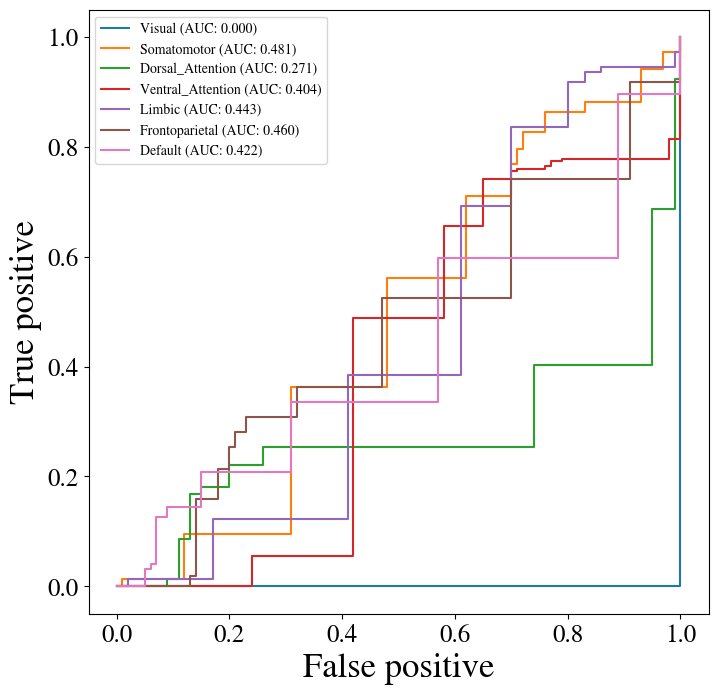

In [55]:
plt.figure(figsize=[8, 8])
for net_ix in range(1, 8):
    plt.plot(
        result_all[net_ix].fpr, 
        result_all[net_ix].tpr, 
        label=f"{yeo_7nets_dict[net_ix]} (AUC: {result_all[net_ix].auc:.3f})"
    )
    
plt.xlabel("False positive")
plt.ylabel("True positive")
plt.legend(fontsize=10)

## Logi (All disease vs HC)

In [23]:
Y = np.array(diag_labs);
Y[Y==6] = 0
Y[Y>0] = 1

model = LogisticRegression(random_state=0, C=1)

LogisticRegression(C=1, random_state=0)

In [24]:
eprobs = _LOO_CV(Xs, Y, model, verbose=True);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 402.31it/s]


In [25]:
auc = roc_auc_score(Y, eprobs[:, 1])
fpr, tpr, thresholds = roc_curve(Y, eprobs[:, 1], pos_label=1)

Text(0.5, 1.0, 'Disease vs HC (AUC:0.538)')

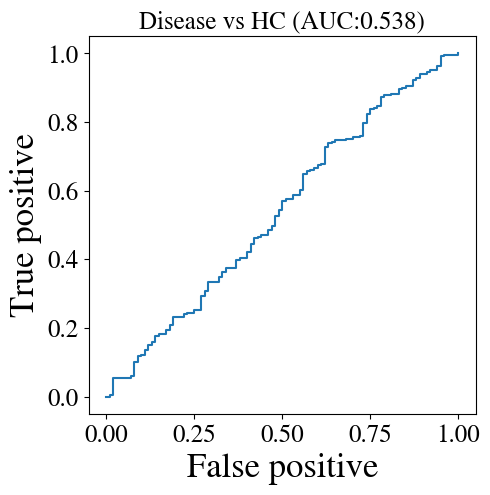

In [26]:
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr)
plt.xlabel("False positive")
plt.ylabel("True positive")
plt.title(f"Disease vs HC (AUC:{auc:.3f})")

## Each vs HC

In [27]:
result_all = {}
for disease_ix in range(1, 6):
    kp_idxs = np.bitwise_or(diag_labs==disease_ix, diag_labs==6);
    cur_Xs = Xs[kp_idxs]
    cur_Y = diag_labs[kp_idxs];
    cur_Y[cur_Y==disease_ix] = 1
    cur_Y[cur_Y==6] = 0
    model = LogisticRegression(random_state=0, C=1)
    cur_eprobs = _LOO_CV(cur_Xs, cur_Y, model, verbose=True);
    auc = roc_auc_score(cur_Y, cur_eprobs[:, 1])
    fpr, tpr, thresholds = roc_curve(cur_Y, cur_eprobs[:, 1], pos_label=1)
    result_all[disease_ix] = edict()
    result_all[disease_ix].eprobs = cur_eprobs
    result_all[disease_ix].auc = auc
    result_all[disease_ix].fpr = fpr 
    result_all[disease_ix].tpr = tpr 
    result_all[disease_ix].thre = thresholds

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 431.97it/s]


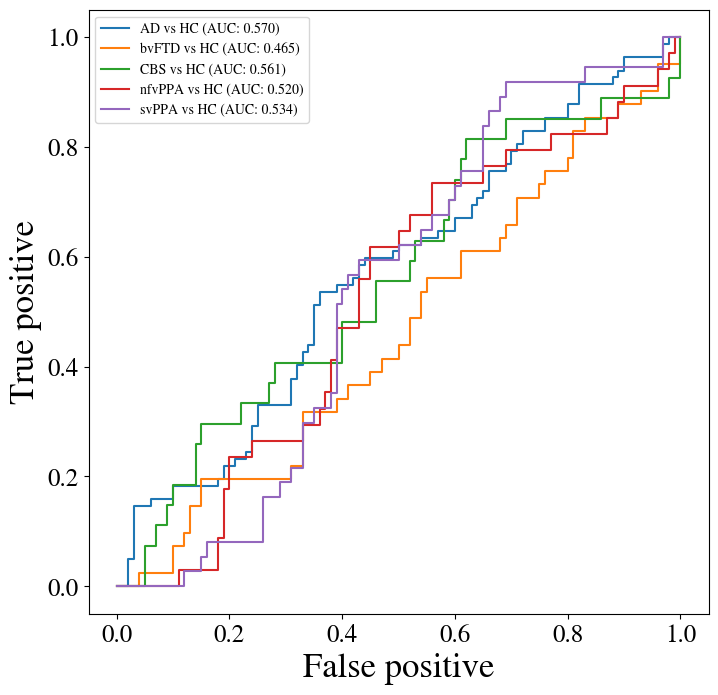

In [28]:
plt.figure(figsize=[8, 8])
for disease_ix in range(1, 6):
    plt.plot(
        result_all[disease_ix].fpr, 
        result_all[disease_ix].tpr, 
        label=f"{diag_lab_mapping[disease_ix]} vs HC (AUC: {result_all[disease_ix].auc:.3f})"
    )
    
plt.xlabel("False positive")
plt.ylabel("True positive")
plt.legend(fontsize=10)

## Mutinomial regression

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
Y = np.array(diag_labs)
model = LogisticRegression(random_state=0, C=1)

LogisticRegression(C=1, random_state=0)

In [31]:
pred_Y = _LOO_CV(Xs, Y, model, verbose=True);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:02<00:00, 134.72it/s]


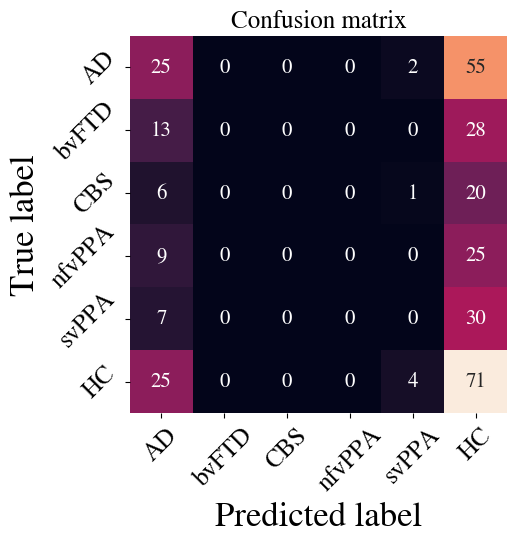

In [32]:
cm = confusion_matrix(Y, pred_Y);
sns.heatmap(cm, annot=True, square=True, cbar=False)
plt.yticks(np.arange(6)+0.5, 
           [diag_lab_mapping[disease_ix] for disease_ix in range(1, 7)], 
          rotation=45)
plt.xticks(np.arange(6)+0.5, 
           [diag_lab_mapping[disease_ix] for disease_ix in range(1, 7)], 
          rotation=45)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion matrix");

# Regression inference

In [59]:
import statsmodels.api as sm
from scipy.stats import ttest_ind, mannwhitneyu

## Logi (All vs HC)

In [27]:
Y = np.array(diag_labs);
Y[Y==6] = 0
Y[Y>0] = 1
stdXs = stdX_fn(Xs);

model = sm.Logit(Y, sm.add_constant(stdXs))
results = model.fit()

Optimization terminated successfully.
         Current function value: 2.729481
         Iterations 5


In [29]:
table1 = results.summary().tables[0]

Dep. Variable:,y,No. Observations:,321
Model:,Logit,Df Residuals:,313
Method:,MLE,Df Model:,7
Date:,"Wed, 22 Nov 2023",Pseudo R-squ.:,inf
Time:,10:22:59,Log-Likelihood:,-876.16
converged:,True,LL-Null:,0.0000
Covariance Type:,nonrobust,LLR p-value:,1.000


In [31]:
table = results.summary().tables[1]
table_df = pd.DataFrame(table.data[1:], columns=table.data[0])
table_df.iloc[:, 0] =  ["Constant"] + [yeo_7nets_dict[net_ix] for net_ix in range(1, 8)]
table_df

,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,0.8277,0.125,6.646,0.000,0.584,1.072
1,Visual,-0.0499,0.132,-0.377,0.706,-0.309,0.209
2,Somatomotor,0.3213,0.136,2.355,0.019,0.054,0.589
3,Dorsal_Attention,-0.1119,0.137,-0.816,0.415,-0.381,0.157
4,Ventral_Attention,0.1182,0.137,0.866,0.387,-0.149,0.386
5,Limbic,0.2188,0.119,1.836,0.066,-0.015,0.452
6,Frontoparietal,-0.1469,0.141,-1.042,0.297,-0.423,0.129
7,Default,-0.2581,0.151,-1.708,0.088,-0.554,0.038


## Logi (Each vs HC)

In [39]:
result_all = {}
for disease_ix in range(1, 6):
    kp_idxs = np.bitwise_or(diag_labs==disease_ix, diag_labs==6);
    cur_Xs = Xs[kp_idxs]
    cur_Y = diag_labs[kp_idxs];
    cur_Y[cur_Y==disease_ix] = 1
    cur_Y[cur_Y==6] = 0
    std_cur_Xs = stdX_fn(cur_Xs)
    model = sm.Logit(cur_Y, sm.add_constant(std_cur_Xs))
    results = model.fit()
    table1 = results.summary().tables[0]
    table = results.summary().tables[1]
    table_df = pd.DataFrame(table.data[1:], columns=table.data[0])
    table_df.iloc[:, 0] =  ["Constant"] + [yeo_7nets_dict[net_ix] for net_ix in range(1, 8)]
    
    results = model.fit()
    result_all[disease_ix] = edict()
    result_all[disease_ix].table1 = pd.DataFrame(table1)
    result_all[disease_ix].table2 = table_df


Optimization terminated successfully.
         Current function value: 64.664001
         Iterations 5
Optimization terminated successfully.
         Current function value: 64.664001
         Iterations 5
Optimization terminated successfully.
         Current function value: 182.618782
         Iterations 5
Optimization terminated successfully.
         Current function value: 182.618782
         Iterations 5
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn

In [40]:
for disease_ix in range(1, 6):
    print(diag_lab_mapping[disease_ix])
    display(result_all[disease_ix].table2)

AD


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-0.2107,0.156,-1.349,0.177,-0.517,0.095
1,Visual,-0.2500,0.167,-1.497,0.135,-0.577,0.077
2,Somatomotor,0.3263,0.178,1.833,0.067,-0.023,0.675
3,Dorsal_Attention,-0.1329,0.166,-0.800,0.424,-0.459,0.193
4,Ventral_Attention,0.0288,0.175,0.164,0.869,-0.314,0.372
5,Limbic,0.3102,0.172,1.798,0.072,-0.028,0.648
6,Frontoparietal,-0.0775,0.172,-0.451,0.652,-0.415,0.260
7,Default,-0.4661,0.190,-2.459,0.014,-0.838,-0.095


bvFTD


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-0.9391,0.194,-4.850,0.000,-1.319,-0.560
1,Visual,-0.0685,0.194,-0.353,0.724,-0.449,0.312
2,Somatomotor,0.3312,0.223,1.484,0.138,-0.106,0.769
3,Dorsal_Attention,-0.0215,0.201,-0.107,0.915,-0.416,0.373
4,Ventral_Attention,0.1522,0.210,0.724,0.469,-0.260,0.564
5,Limbic,0.1578,0.209,0.756,0.450,-0.251,0.567
6,Frontoparietal,-0.2351,0.199,-1.183,0.237,-0.625,0.154
7,Default,-0.2248,0.204,-1.100,0.271,-0.625,0.176


CBS


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-1.4656,0.249,-5.891,0.000,-1.953,-0.978
1,Visual,0.4179,0.316,1.321,0.187,-0.202,1.038
2,Somatomotor,0.2920,0.287,1.016,0.310,-0.271,0.856
3,Dorsal_Attention,-0.0075,0.247,-0.030,0.976,-0.491,0.476
4,Ventral_Attention,0.4266,0.275,1.553,0.120,-0.112,0.965
5,Limbic,-0.0402,0.242,-0.166,0.868,-0.515,0.434
6,Frontoparietal,-0.3603,0.232,-1.550,0.121,-0.816,0.095
7,Default,-0.1225,0.274,-0.448,0.654,-0.659,0.414


nfvPPA


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-1.2117,0.226,-5.360,0.000,-1.655,-0.769
1,Visual,0.0124,0.222,0.056,0.955,-0.422,0.447
2,Somatomotor,0.2785,0.258,1.080,0.280,-0.227,0.784
3,Dorsal_Attention,0.2914,0.271,1.076,0.282,-0.239,0.822
4,Ventral_Attention,0.5193,0.272,1.911,0.056,-0.013,1.052
5,Limbic,0.0745,0.223,0.334,0.738,-0.363,0.512
6,Frontoparietal,0.0640,0.235,0.273,0.785,-0.396,0.524
7,Default,-0.3132,0.246,-1.275,0.202,-0.795,0.168


svPPA


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-1.1537,0.225,-5.123,0.000,-1.595,-0.712
1,Visual,0.1212,0.231,0.524,0.600,-0.332,0.575
2,Somatomotor,0.3641,0.238,1.528,0.127,-0.103,0.831
3,Dorsal_Attention,-0.2135,0.204,-1.045,0.296,-0.614,0.187
4,Ventral_Attention,-0.1897,0.216,-0.878,0.380,-0.613,0.234
5,Limbic,0.7143,0.327,2.186,0.029,0.074,1.355
6,Frontoparietal,-0.1749,0.215,-0.813,0.416,-0.597,0.247
7,Default,0.0977,0.257,0.381,0.704,-0.406,0.601


In [45]:
diag_lab_mapping, yeo_7nets_dict

({1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'},
 {1: 'Visual',
  2: 'Somatomotor',
  3: 'Dorsal_Attention',
  4: 'Ventral_Attention',
  5: 'Limbic',
  6: 'Frontoparietal',
  7: 'Default'})

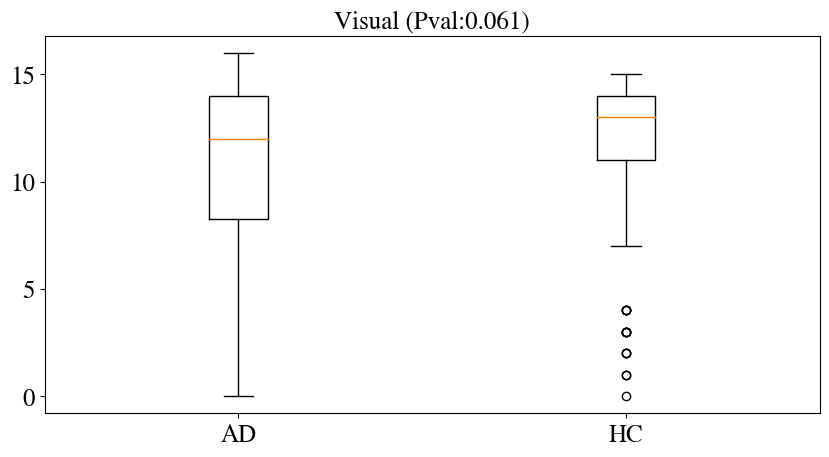

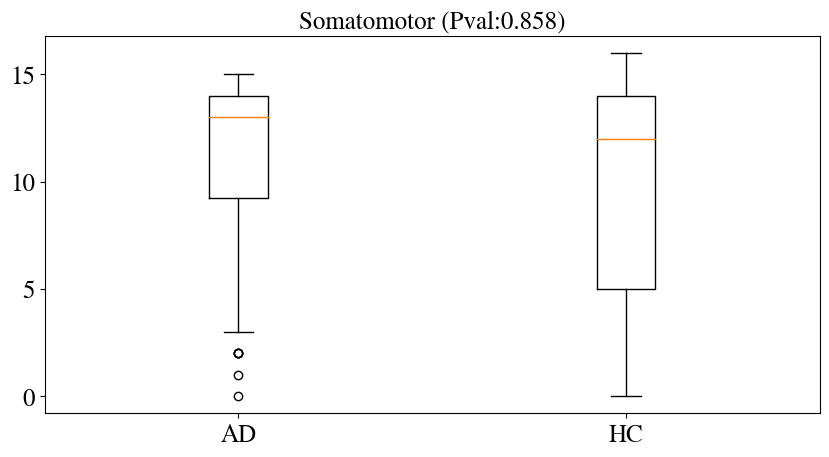

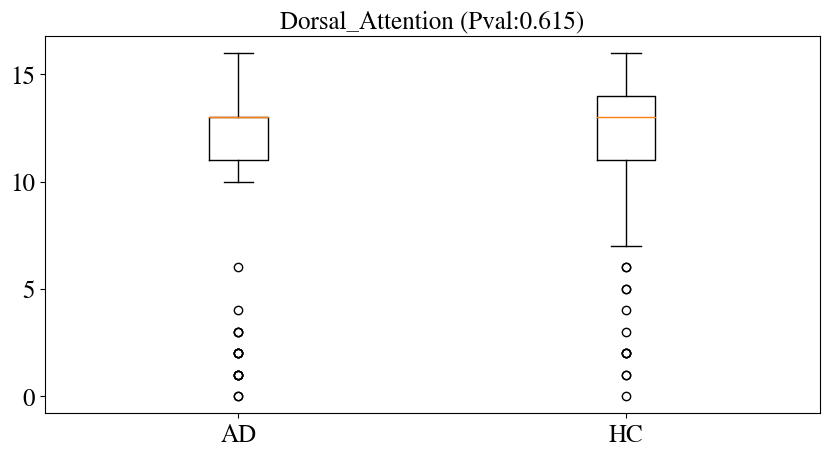

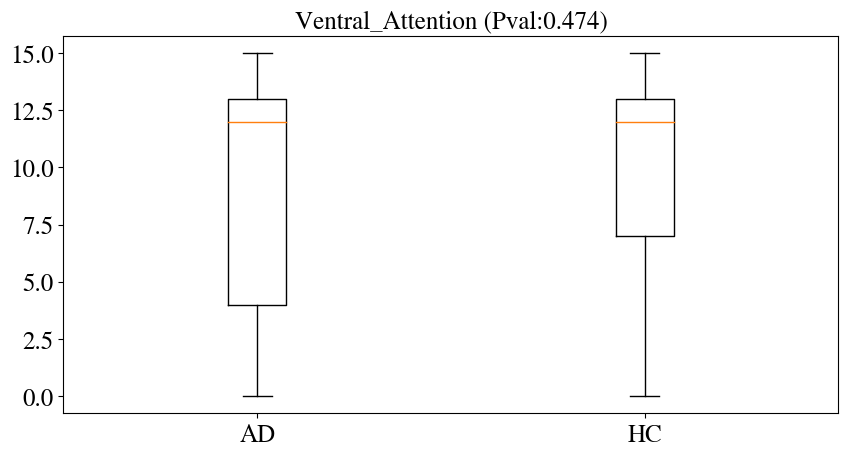

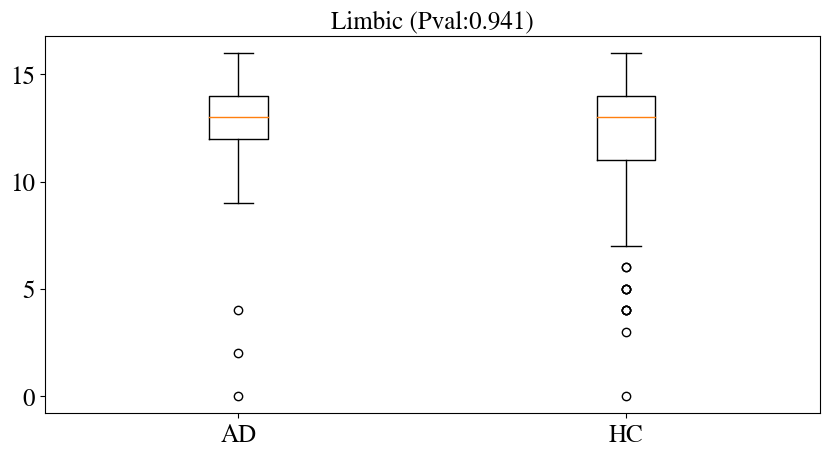

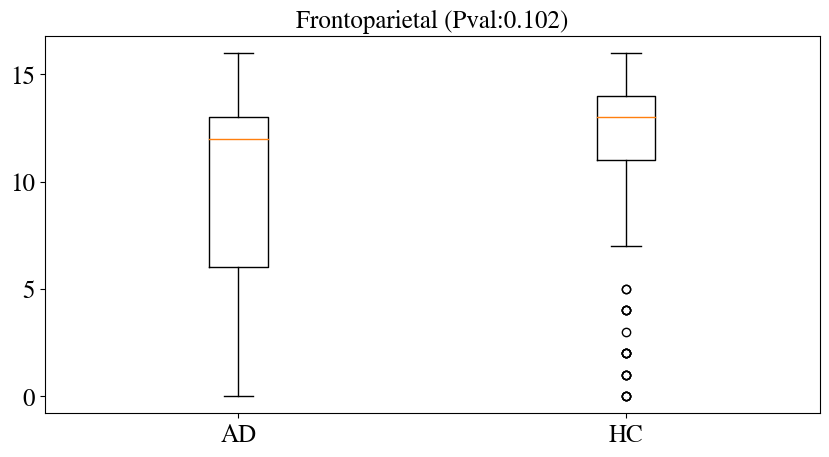

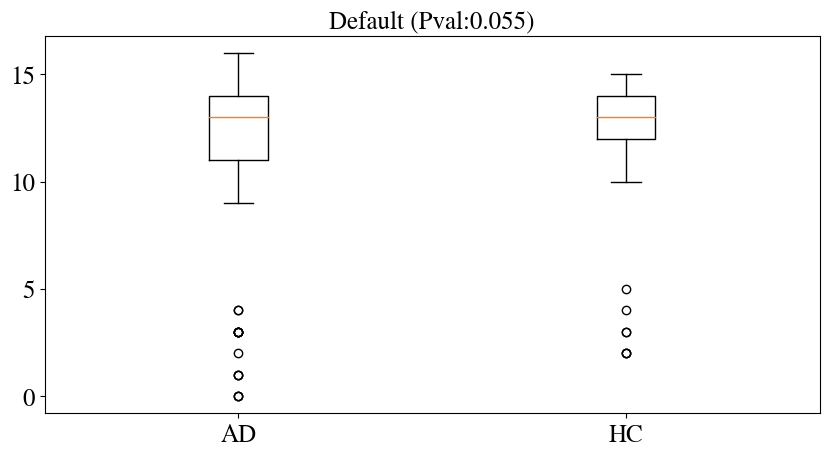

In [65]:
disease_ix =1
net_ix = 7
for net_ix in range(1, 8):
    kp_idxs = np.bitwise_or(diag_labs==1, diag_labs==6);
    cur_Y = diag_labs[kp_idxs];
    cur_Xs = Xs[kp_idxs];
    cur_X = cur_Xs[:, net_ix-1]
    vec1, vec2 = cur_X[cur_Y==1], cur_X[cur_Y==6]
    test_res = mannwhitneyu(vec1, vec2)
    test_res2 = ttest_ind(vec1, vec2);
    
    plt.boxplot([vec1, vec2]);
    plt.xticks([1, 2], ["AD", "HC"])
    plt.title(f"{yeo_7nets_dict[net_ix]} (Pval:{test_res.pvalue:.3f})")
    plt.show()
    plt.close()